## notes
* weird behavior for input frequency in the ranges [978.6, 988.2] and [2303.4, 2313.0] MHz - data is extremely noisy regardless of actual signal
* input can only operate in 1st Nyquist zone (rolls off rapidly above 1.2 GHz) - might be able to change the coarse mixer?
* output PFB channels randomly have pi phase shifts (positive or negative amplitude) - should be possible to calibrate

In [1]:
# import sys
# sys.path.append('../qick/qick_lib/')

from mkids_4x1024 import TopSoc
from numpy.fft import fftshift
from scipy.signal import welch
# from scipy.interpolate import interp1d
from tqdm.auto import tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = TopSoc('./mkids_4x1024.bit', force_init_clks=True)

resetting clocks: 245.76 491.52


## calibrate PFB gains
This does not rely on any other calibration, but the output gain must be calibrated before the input gain.

In [11]:
# measure the output gain as a function of PFB frequency offset
# we can keep the real freq fixed (so the input gain doesn't change), and sweep the mixer freq

# real freq
fout = 500 # MHz
fout = np.round(fout/soc.pfb_out.fc)*soc.pfb_out.fc
print(fout)

# mixer range
fstart = 0
fcenter = soc.pfb_out.fb*0.5
fstop = soc.pfb_out.fb

fmix = fcenter

soc.pfb_out.qout(0)
# get K and PFB frequency, which don't change during the sweep
soc.set_mixer(fmix)
K, dds_freq, pfb_freq, ch = soc.pfb_out.freq2ch(fout, fmix)

freqs = soc.round_freq(np.linspace(fstart,fstop,513))[1:] # drop the first point
results_complex = np.zeros_like(freqs,dtype=complex)
for i, fmix in enumerate(tqdm(freqs)):
    soc.set_mixer(fmix)

    soc.dds_out.alloff()
    fdds = soc.round_freq(fout - fmix - pfb_freq) # Hz
    soc.dds_out.ddscfg(f=fdds, g=0.1, ch=K)

    soc.set_inputs([fout], decimation=2, downconvert=True)
    results_complex[i] = soc.read(equalize=False)
gains = np.abs(results_complex)
normalized_freqs = (freqs-fcenter)/soc.pfb_out.fb

499.2


  0%|          | 0/512 [00:00<?, ?it/s]

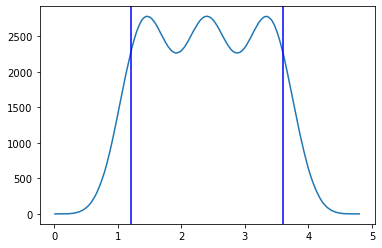

In [12]:
plt.plot(freqs, gains)
for i in [-0.25, 0.25]:
    plt.axvline(fcenter + soc.pfb_out.fb*(i), color='blue')

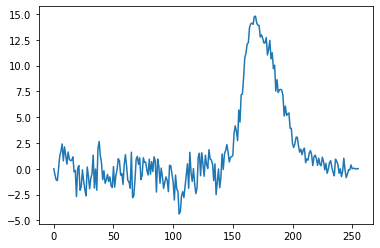

In [13]:
# normalize and save
center = len(gains)//2 - 1
forward_gains = gains[center:]
backward_gains = gains[center::-1]
plt.plot(forward_gains[:-1]-backward_gains) # check symmetry
forward_gains[:-1] += backward_gains
forward_gains[:-1] *= 0.5
# print(forward)
forward_freqs = normalized_freqs[center:]
forward_gains /= forward_gains[0] # normalize to center frequency

In [ ]:
# uncomment to save
# np.save("output_gain.npy",np.stack([forward_freqs, forward_gains]))

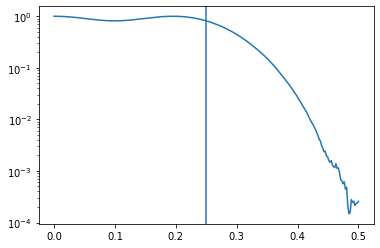

In [14]:
plt.semilogy(*np.load("output_gain.npy"))
plt.axvline(0.25) # maximum frequency offset in normal use

In [81]:
# now that the output gain is equalized, we can measure the input gain

fmix = 0 # MHz

# real freq range
fstart = 500 # MHz
fstart = np.round(fstart/soc.pfb_in.fc)*soc.pfb_in.fc
fcenter = fstart + soc.pfb_in.fb*0.5
fstop = fstart + soc.pfb_in.fb

soc.set_mixer(fmix)

soc.pfb_in.qout(7)
decimation = 2
soc.ddscic.decimation(value=decimation)
soc.ddscic.dds_outsel(outsel="product")

K, dds_freq, pfb_freq, ch = soc.pfb_in.freq2ch(fcenter)

# Channel number.
soc.chsel.set_single(K)

soc.input_config['streamer_ch'] = np.array([soc.chsel.ch2idx(K)])
soc.input_config['offset'] = np.array([1.0])

freqs = soc.round_freq(np.linspace(fstart,fstop,33)[:-1]) # drop the last point
results_complex = np.zeros_like(freqs,dtype=complex)
for i, fout in enumerate(tqdm(freqs)):
    soc.set_outputs([fout], 0.1, equalize=True)
    
    # Set DDS frequency.
    dds_freq = soc.round_freq(fout - pfb_freq)
    soc.ddscic.set_ddsfreq(ch_id=K, f=dds_freq)

    results_complex[i] = soc.read(equalize=False)[0]
    
gains = np.abs(results_complex)
normalized_freqs = (freqs-fcenter)/soc.pfb_in.fb

  0%|          | 0/32 [00:00<?, ?it/s]

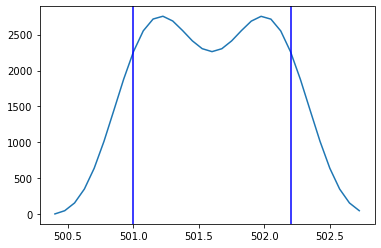

In [82]:
plt.plot(freqs, gains)
for i in [-0.25, 0.25]:
    plt.axvline(fcenter + soc.pfb_in.fb*(i), color='blue')

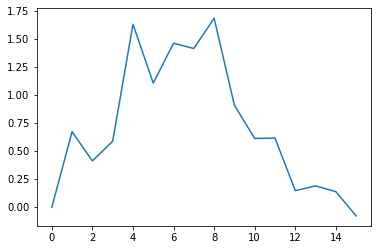

In [83]:
# normalize and save
center = len(gains)//2
forward_gains = gains[center:]
backward_gains = gains[center::-1]
plt.plot(backward_gains[:-1]-forward_gains) # check symmetry
backward_gains[:-1] += forward_gains
backward_gains[:-1] *= 0.5
backward_freqs = -1*normalized_freqs[center::-1]
backward_gains /= backward_gains[0] # normalize to center frequency


In [ ]:
# uncomment to save
# np.save("input_gain.npy",np.stack([backward_freqs, backward_gains]))

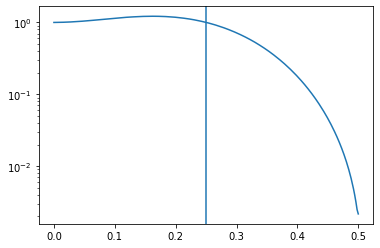

In [84]:
plt.semilogy(*np.load("input_gain.npy"))
plt.axvline(0.25) # maximum frequency offset in normal use

## calibrate phase jumps
This does not depend on any other calibration, as long as a frequency range is used that doesn't have sign flips.

In [89]:
from scipy.optimize import least_squares

def wrap_phase(phases):
    """take an angle and fold it into the range [-pi,pi)"""
    return ((phases+np.pi) % (2*np.pi))-np.pi

def phase_residuals(data, prediction):
    """calculate residual between observed and predicted phases"""
    return wrap_phase(data-prediction)
    
def phase_model(x, freqs, fmix):
    """predicted phase shift"""
    offset, slope, output_step, input_step = x
    n_output_steps = soc.pfb_out.freq2ch(freqs,fmix)[3]
    n_input_steps = soc.pfb_in.freq2ch(freqs)[3]
    
    phases = offset + slope*freqs + output_step*n_output_steps + input_step*n_input_steps
    return wrap_phase(phases)

def phase_func(x, freqs, phases, fmix):
    """residuals function to be minimized"""
    return phase_residuals(phases, phase_model(x, freqs, fmix))

def initial_guess(freqs, phases, fmix):
    dphase = phases[1:]-phases[:-1]
    dfreq = freqs[1:]-freqs[:-1]
    slopes = dphase/dfreq
    output_step = wrap_phase(dphase[-1])
    input_step = wrap_phase(dphase[(len(phases-1)//2)-1])
    slope = np.median(slopes)
    x0 = np.array([0.0, slope, output_step, input_step])
    x0[0] = np.median(phase_residuals(phases,phase_model(x0, freqs, fmix)))
    return x0

  0%|          | 0/21 [00:00<?, ?it/s]

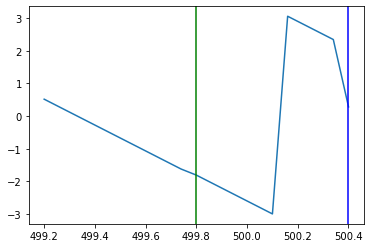

In [87]:
# measure the phase as a function of PFB frequency offset
# we must keep the mixer fixed, because the mixer is not phase-coherent
def edges(start, stop, spacing, offset=0):
    offset_phase = (0.5+offset/spacing)%1
    return spacing * np.arange(start/spacing + ((offset_phase - start/spacing) % 1), stop/spacing)

eps = 0.001

fmix = 0 # MHz
fstart = 500 # MHz
# fmix_mod = fmix % soc.pfb_out.fc
# fstart = np.round((fstart-fmix_mod)/soc.pfb_out.fc)*soc.pfb_out.fc + fmix_mod
fstart = np.round((fstart)/soc.pfb_out.fc)*soc.pfb_out.fc
fstop = fstart + 0.5*soc.pfb_out.fc+eps
truncate = 200

soc.set_mixer(fmix)
freqs = soc.round_freq(np.linspace(fstart,fstop,21))
results_complex = np.zeros_like(freqs, dtype=complex)
for i, fout in enumerate(tqdm(freqs)):
    results_complex[i] = soc.measure([fout], 0.1, equalize=False)

phases = np.angle(results_complex)
plt.plot(freqs, phases)
output_edges = edges(fstart, fstop, soc.pfb_out.fc, fmix%soc.pfb_out.fc)
input_edges = edges(fstart, fstop, soc.pfb_in.fc)
for f in output_edges:
    plt.axvline(f, color='blue')
for f in input_edges:
    plt.axvline(f, color='green')

initial estimate: -2.22 rad shift, -3.953 rad/MHz slope, -2.060 rad output step, -0.185 rad input step
after minimization: -150.53 rad shift, -3.953 rad/MHz slope, -1.822 rad output step, 0.052 rad input step


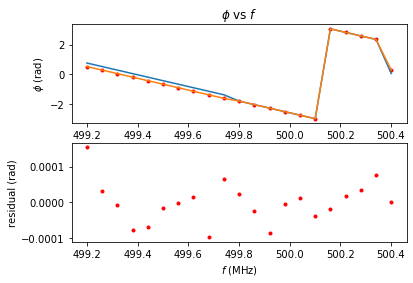

In [90]:
x0 = initial_guess(freqs, phases, fmix)

print("initial estimate: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(x0))
fit = least_squares(phase_func, x0, args=(freqs, phases, fmix))
# print(fit.status)
print("after minimization: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(fit.x))

fig, axs = plt.subplots(2)
plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs, phases, marker='.', linestyle="None",color="Red")
plot.plot(freqs, phase_model(x0, freqs, fmix))
plot.plot(freqs, phase_model(fit.x, freqs, fmix))

plot = axs[1]
plot.set_ylabel(r"residual (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs, phase_func(fit.x, freqs, phases, fmix), marker='.', linestyle="None",color="Red")

  0%|          | 0/101 [00:00<?, ?it/s]

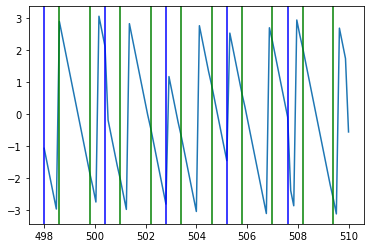

In [91]:
fmix = 0 # MHz
fstart = 498 # MHz
fstop = 510
truncate = 200

fmix = soc.set_mixer(fmix)
freqs = soc.round_freq(np.linspace(fstart,fstop,101))
results_complex = np.zeros_like(freqs, dtype=complex)
for i, fout in enumerate(tqdm(freqs)):
    results_complex[i] = soc.measure([fout], 0.1, equalize=False)

phases = np.angle(results_complex)
plt.plot(freqs, phases)
output_edges = edges(fstart, fstop, soc.pfb_out.fc, fmix%soc.pfb_out.fc)
input_edges = edges(fstart, fstop, soc.pfb_in.fc)
for f in output_edges:
    plt.axvline(f, color='blue')
for f in input_edges:
    plt.axvline(f, color='green')

initial estimate: -150.53 rad shift, -3.953 rad/MHz slope, -1.822 rad output step, 0.052 rad input step
after minimization: -150.22 rad shift, -3.954 rad/MHz slope, -1.822 rad output step, 0.052 rad input step


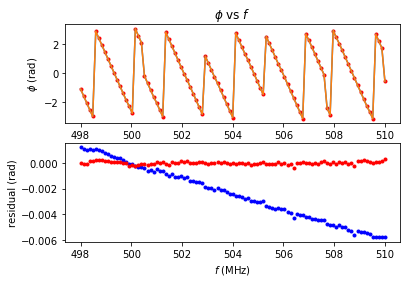

In [92]:
x0 = fit.x
print("initial estimate: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(x0))
fit = least_squares(phase_func, x0, args=(freqs, phases, fmix))
# print(fit.status)
print("after minimization: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(fit.x))

fig, axs = plt.subplots(2)
plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs,phases, marker='.', linestyle="None",color="Red")
plot.plot(freqs, phase_model(x0, freqs, fmix))
plot.plot(freqs, phase_model(fit.x, freqs, fmix))

plot = axs[1]
plot.set_ylabel(r"residual (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs, phase_func(x0, freqs, phases, fmix), marker='.', linestyle="None",color="Blue")
plot.plot(freqs, phase_func(fit.x, freqs, phases, fmix), marker='.', linestyle="None",color="Red")

The shift is an arbitrary phase offset and changes when the mixer is manipulated.
The slope depends on cable length, but is dominated by some sort of phase shift that occurs as you sweep across the PFB channels (probably relative latency of the input and output DDS resets).

In [94]:
print(fit.x)
print((fit.x[1]*2.4 + fit.x[2] + 2*fit.x[3])/np.pi)

[-1.50221341e+02 -3.95392480e+00 -1.82230462e+00  5.22086096e-02]
-3.567396592651623


In [109]:
soc.PHASE_STEP_OUTPUT = fit.x[2]
soc.PHASE_STEP_INPUT = fit.x[3]
soc.PHASE_SLOPE = fit.x[1]

### correct output sign flips
The phase calibration must have been performed.

In [105]:
# wipe out the output_signs calibration so we can rerun it
soc.output_signs = np.ones(soc.pfb_out.N)

  0%|          | 0/306 [00:00<?, ?it/s]

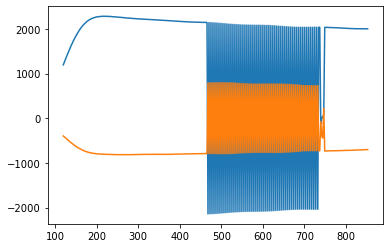

In [110]:
fmix = soc.pfb_out.fc*(50+soc.pfb_out.N//2) # MHz
freqs = soc.pfb_out.fc*np.arange(50, 100+soc.pfb_out.N//2)

fmix = soc.set_mixer(fmix)
results_complex = np.zeros_like(freqs, dtype=complex)
for i, fout in enumerate(tqdm(freqs)):
    results_complex[i] = soc.measure([fout], 0.1, equalize=True)
plt.plot(freqs, np.real(results_complex))
plt.plot(freqs, np.imag(results_complex))

In [111]:
output_sign = np.zeros(soc.pfb_out.N,dtype=int)

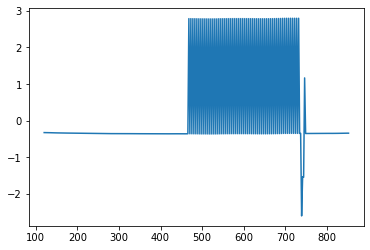

In [114]:
plt.plot(freqs, np.angle(results_complex))
output_n = soc.pfb_out.freq2ch(freqs,fmix)[0]
ch0 = results_complex[(soc.pfb_out.freq2ch(freqs,fmix)[0]==0)]
signs = np.sign(np.pi/2 - np.abs(np.angle(results_complex/ch0)))
# np.stack([output_n, signs]).T
output_sign[output_n] = signs

In [115]:
output_sign

array([ 1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

  0%|          | 0/306 [00:00<?, ?it/s]

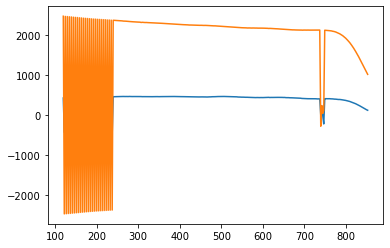

In [116]:
fmix = soc.pfb_out.fc*(100) # MHz
freqs = soc.pfb_out.fc*np.arange(50, 100+soc.pfb_out.N//2)

fmix = soc.set_mixer(fmix)
results_complex = np.zeros_like(freqs, dtype=complex)
for i, fout in enumerate(tqdm(freqs)):
    results_complex[i] = soc.measure([fout], 0.1, equalize=True)
plt.plot(freqs, np.real(results_complex))
plt.plot(freqs, np.imag(results_complex))


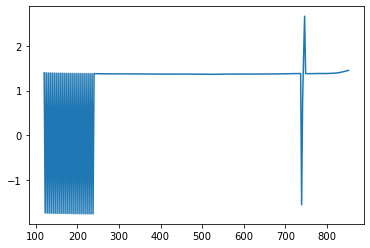

In [117]:
plt.plot(freqs, np.angle(results_complex))
output_n = soc.pfb_out.freq2ch(freqs,fmix)[0]
ch0 = results_complex[(soc.pfb_out.freq2ch(freqs,fmix)[0]==0)]
signs = np.sign(np.pi/2 - np.abs(np.angle(results_complex/ch0)))
output_sign[output_n] = signs


In [118]:
output_sign

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [ ]:
# uncomment to save
# np.save("output_sign.npy",output_sign)